In [1]:
IRdisplay::display_html('<style>.container { width:90% !important; }</style>')

In [1]:
# make countMatrices with 
#.../pathogen_pipeline/makeBenchmarkDataframe.ipynb

library(tidyr)
library(DESeq2)
library(ggplot2)
library(reshape2)
library(dplyr)
library(Rtsne)
library(caret)
library(randomForest)

getTrainTestSet = function(data, percentageTraining = 0.9){
    smp_siz = floor(percentageTraining*nrow(data))
    set.seed(123)
    train_ind = sample(seq_len(nrow(data)),size = smp_siz)
    train = data[train_ind,]
    test = data[-train_ind,]
    returnvalues = list("train" = train, "test" = test)
    return(returnvalues)
}


title_tsne <- cowplot::ggdraw() + cowplot::draw_label("TSNE", fontface='bold', x = 0, hjust = 0)
title_pca <- cowplot::ggdraw() + cowplot::draw_label("PCA", fontface='bold', x = 0, hjust = 0)

ERROR: Error in library(tidyr): there is no package called ‘tidyr’


In [3]:
preparePCAandTSNEplots = function(tsne, pca, metadata_of_interest){

    data_to_plot <- cbind(data.frame(tSNE_1 = tsne$Y[,1], tSNE_2 = tsne$Y[,2]), metadata_of_interest)
    features_to_plot <- setdiff(colnames(data_to_plot), c("tSNE_1", "tSNE_2"))
    features_to_plot <- setNames(features_to_plot, features_to_plot)
    all_plots_tsne <- lapply(features_to_plot,
           function(col) ggplot(data = data_to_plot) +
                        geom_point(aes(x = tSNE_1, y = tSNE_2, color = !!sym(col))) +
                        theme(legend.position = "bottom", legend.title = element_text(size = 10),
                        legend.text = element_text(size = 10)) + xlab("") + ylab("")
    )

    data_to_plot <- cbind(data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2]), metadata_of_interest)
    features_to_plot <- setdiff(colnames(data_to_plot), c("PC1", "PC2"))
    features_to_plot <- setNames(features_to_plot, features_to_plot)
    all_plots_pca <- lapply(features_to_plot,
           function(col) ggplot(data = data_to_plot) +
                        geom_point(aes(x = PC1, y = PC2, color = !!sym(col))) +
                        theme(legend.position = "bottom", legend.title = element_text(size = 10),
                        legend.text = element_text(size = 10)) + xlab("") + ylab("") #+ xlim(-5,5) + ylim(-5,5)
    )
    plotsList = list("all_plots_tsne" = all_plots_tsne, "all_plots_pca" = all_plots_pca)
    return(plotsList)
}

#printDEresults = function(countData, samples, metadata_of_interest, DEcolumn, pvalue_cutoff, padjV = TRUE, plotFunction = geom_point()){
#    
#    dds <- DESeqDataSetFromMatrix(countData = countData[,samples],
#                              colData = metadata_of_interest[samples,],
#                              design= formula(paste("~",DEcolumn)))
#    dds <- DESeq(dds)
#    print(resultsNames(dds))
#    deres = as.data.frame(results(dds, name=resultsNames(dds)[2]))
#    if(padjV){
#        deres = deres[!is.na(deres$padj) & deres$padj<pvalue_cutoff,]        
#    } else {
#        deres = deres[!is.na(deres$pvalue) & deres$pvalue<pvalue_cutoff,]         
#    }
printDEresults = function(countData, samples, taxIDs, metadata_of_interest, DEcolumn, plotFunction = geom_point()){
   
    t = countData[taxIDs,samples] 
    t = add_rownames(t)
    t = gather(t, key = "sample", value = "expression", -rowname)
    md = metadata_of_interest[t$sample,]
    t = cbind(t, cc = md[,DEcolumn])
    ggplot(t, aes(x = cc, y = expression)) +
        plotFunction + 
        geom_smooth(method = "lm") +
        stat_summary(fun.y=mean, geom="point", shape=95, size=12, color="blue") + 
        stat_summary(fun.y=median, geom="point", size=2, color="red") +
        facet_wrap(facets = vars(rowname), scales = "free", ncol=5) + 
        ggtitle(paste("red = median , blue = mean"))    
    #return(list("deresults"= deres[order(deres$log2FoldChange, decreasing = TRUE),], "significantCounts" = countData[rownames(deres),],"plots"=p))
}

In [4]:
inputfolder = "/projectbig/jupyternotebook/anna/pathogen_pipeline/OUTPUT/FTD/"
ds = "FTD"

# FTD mRNA

In [47]:
pca_outlier = c()

In [62]:
counts = read.table(paste0(inputfolder,ds,"_contamination_aggregated.csv"), sep = ",", header=TRUE, check.names = FALSE, row.names = "")

if(exists("pca_outlier")){
    print(pca_outlier)
    counts = counts[,!(colnames(counts) %in% pca_outlier)]
} else {
    pca_outlier = c()
}

pathoInfoCols = c("species_name","phylo_level","parent")
pathoInfo = counts[pathoInfoCols]
counts = counts[,!colnames(counts) %in% pathoInfoCols]

counts[is.na(counts)]=0
counts

[1] "07083" "05217" "A144_"


,98169,00116,00136,02218,03121,04245,04263,05052,05108,05150,⋯,12001,12005,12042,12062,92017,95231,96303,97231,97303,98061
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1969841,784878,787603,1767160,815657,409385,658210,611432,674349,1011913,729985,⋯,494180,1232338,721444,520557,983627,531811,966923,908890,600373,527048
1491,275687,211559,565891,107180,135795,157907,129659,180864,287619,123936,⋯,164326,302256,211633,175128,281413,115404,370109,102240,97523,122184
44283,250349,178052,314226,193425,84103,82057,115603,150475,247195,121768,⋯,116290,380059,180750,160643,193625,88567,203249,190972,105667,150929
2184519,182899,146714,338136,92401,90792,140170,88644,122950,190231,89462,⋯,113399,187675,133276,114146,179315,82865,255550,97202,70975,94973
72407,148016,111606,219617,203689,95668,125445,109171,110018,140268,121389,⋯,107351,218914,127300,118961,154373,94710,127610,201013,150345,105778
166122,108947,72110,168005,195923,70490,109628,94213,69296,116288,89576,⋯,68343,154073,101008,100604,107446,63142,84112,178360,111986,84712
550,70922,57438,130686,113399,47216,66979,55349,55215,62535,49731,⋯,52368,115267,60772,57651,73459,45680,58092,118177,85011,49954
485,36097,31883,51442,52549,31771,35855,33252,31540,37156,36666,⋯,33684,45864,35341,33450,38557,28748,35942,50900,40444,32287
527028,38006,45543,46180,6325,14673,16389,10324,40549,56947,16345,⋯,17034,43520,24657,19844,17491,18665,49042,7106,15270,15075


In [63]:
noOfOutliers = length(pca_outlier)
numberOfZerosAllowed = length(counts)*0.99
counts_lessSparse = counts[!(rowSums(counts == 0) > numberOfZerosAllowed),]
table(duplicated(counts_lessSparse))
counts = counts_lessSparse


FALSE 
  431 

In [64]:
metadata = read.table(paste0(inputfolder,"metadata.csv"))
rownames(metadata) = substr(rownames(metadata),1,5)
metadata = metadata[colnames(counts),]
metadata

t(as.data.frame(table(metadata$REGION)))
t(as.data.frame(table(metadata$MUTATED.GENE)))
table(metadata$CASE.CONTROL)
t(as.data.frame(table(metadata$DISEASE.CODE)))
t(as.data.frame(table(metadata$AGE)))
table(metadata$GENDER)

colnames(metadata)

,FLOWCELL,LANE,SAMPLEID,ORIGINALSAMPLENAME,REGION,CASE.CONTROL,DISEASE.CODE,MUTATED.GENE,GENE,Number_of_input_reads,⋯,PMD.MIN.,PH,Pipeline_Passed,MADE,SENT,LIBRARIES.DONE,NOTE,OBSERVATIONS,SOURCE,ALREADY.IN.GOOGLE
,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,⋯,<fct>,<fct>,<fct>,<int>,<int>,<lgl>,<fct>,<fct>,<lgl>,<fct>
98169,BC894KANXX,5,98169,NA,frontal,case,FTD-C9,C9orf72,C9orf72,14921445,⋯,260,6.25,Yes,NA,NA,NA,NA,NA,NA,NA
00116,BC9AP9ANXX,3,116,NA,frontal,case,FTD-C9,C9orf72,C9orf72,10249720,⋯,330,6.66,Yes,120416,20516,NA,NA,Eldem´s second librarie,NA,Yes
00136,D10RJACXX,2,136,00_136_Frontal,frontal,case,FTD-MAPT,MAPT,P301L,24109642,⋯,300,6.3,Yes,NA,NA,NA,NA,NA,NA,NA
02218,D10MJACXX,8,2218,02_218_frontal,frontal,case,FTD-C9,C9orf72,C9orf72,34304121,⋯,545,6.23,Yes,NA,NA,NA,NA,NA,NA,NA
03121,D2D9FACXX,1,3121,03121_front,frontal,case,FTD-MAPT,MAPT,R406V,26866599,⋯,445,6.6,Yes,NA,NA,NA,NA,NA,NA,NA
04245,D10RJACXX,2,4245,04_245_Frontal,frontal,case,FTD-MAPT,MAPT,P301L,23336035,⋯,400,6.52,Yes,NA,NA,NA,NA,NA,NA,NA
04263,D2D9FACXX,1,4263,04263_front,frontal,case,FTD-MAPT,MAPT,G272V,11479519,⋯,450,6.46,Yes,NA,NA,NA,NA,NA,NA,NA
05052,D2D9FACXX,2,5052,05052_front,frontal,case,FTD-MAPT,MAPT,G272V,31264259,⋯,310,6.54,Yes,NA,NA,NA,NA,NA,NA,NA
05108,D2D9FACXX,3,5108,05108_front,frontal,case,FTD-MAPT,MAPT,L315R,28916964,⋯,340,6.6,Yes,NA,NA,NA,NA,NA,NA,NA


Var1,frontal
Freq,45


Var1,C9orf72,control,GRN,MAPT
Freq,12,15,6,11



   case control 
     30      15 

Var1,control,FTD-C9,FTD-GRN,FTD-MAPT,FTD-sporadic-TDP
Freq,15,12,6,11,1


Var1,42,49,51,52,54,58,59,60,63,64,⋯,74,75,76,82,83,84,85,87,88,89
Freq,1,2,1,2,1,1,1,4,3,3,⋯,1,2,2,1,2,2,1,1,1,2



 F  M 
25 20 

[1] "FLOWCELL"                        "LANE"                           
 [3] "SAMPLEID"                        "ORIGINALSAMPLENAME"             
 [5] "REGION"                          "CASE.CONTROL"                   
 [7] "DISEASE.CODE"                    "MUTATED.GENE"                   
 [9] "GENE"                            "Number_of_input_reads"          
[11] "Number_of_Uniquely_mapped_reads" "Ratio_of_uniquely_mapped_reads" 
[13] "RIN"                             "LINKERS"                        
[15] "BARCODE"                         "POOL"                           
[17] "AGE"                             "GENDER"                         
[19] "PMD"                             "PMD.MIN."                       
[21] "PH"                              "Pipeline_Passed"                
[23] "MADE"                            "SENT"                           
[25] "LIBRARIES.DONE"                  "NOTE"                           
[27] "OBSERVATIONS"                    "SOURCE"                         
[29] "ALREADY.IN.GOOGLE"

In [65]:
cols_of_interest = c('FLOWCELL','LANE','CASE.CONTROL','DISEASE.CODE','MUTATED.GENE','GENE','Number_of_input_reads','RIN','LINKERS','BARCODE','POOL','AGE','GENDER','PMD.MIN.','PH')
metadata_of_interest = metadata[rownames(t(counts)),cols_of_interest]
metadata_of_interest$PMD.MIN. = as.numeric(metadata_of_interest$PMD.MIN.)
metadata_of_interest$PH = as.numeric(metadata_of_interest$PH)
metadata_of_interest

,FLOWCELL,LANE,CASE.CONTROL,DISEASE.CODE,MUTATED.GENE,GENE,Number_of_input_reads,RIN,LINKERS,BARCODE,POOL,AGE,GENDER,PMD.MIN.,PH
,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<int>,<fct>,<int>,<int>,<fct>,<dbl>,<dbl>
98169,BC894KANXX,5,case,FTD-C9,C9orf72,C9orf72,14921445,6.4,9,AGC,NA,68,M,4,4
00116,BC9AP9ANXX,3,case,FTD-C9,C9orf72,C9orf72,10249720,7.6,9,AGC,77,58,M,16,22
00136,D10RJACXX,2,case,FTD-MAPT,MAPT,P301L,24109642,7.8,5,ACT,NA,66,M,10,9
02218,D10MJACXX,8,case,FTD-C9,C9orf72,C9orf72,34304121,6.0,6,ACG,NA,64,F,37,3
03121,D2D9FACXX,1,case,FTD-MAPT,MAPT,R406V,26866599,6.7,4,ACA,NA,75,F,33,20
04245,D10RJACXX,2,case,FTD-MAPT,MAPT,P301L,23336035,7.0,8,ATG,NA,66,F,27,17
04263,D2D9FACXX,1,case,FTD-MAPT,MAPT,G272V,11479519,6.9,3,GAT,NA,54,F,34,15
05052,D2D9FACXX,2,case,FTD-MAPT,MAPT,G272V,31264259,7.5,8,ATG,NA,49,M,12,18
05108,D2D9FACXX,3,case,FTD-MAPT,MAPT,L315R,28916964,7.8,3,GAT,NA,68,F,18,20


In [66]:
metadata_of_interest = cbind(metadata_of_interest,t(counts["95485",rownames(metadata_of_interest)]))
#etadata_of_interest = cbind(metadata_of_interest,t(counts["1286",rownames(metadata_of_interest)]))
#etadata_of_interest = cbind(metadata_of_interest,t(counts["2047",rownames(metadata_of_interest)]))
metadata_of_interest$"95485" = as.factor(metadata_of_interest$"95485")
#metadata_of_interest$"1286" = as.factor(metadata_of_interest$"1286")
#etadata_of_interest$"2047" = as.factor(metadata_of_interest$"2047")
metadata_of_interest

,FLOWCELL,LANE,CASE.CONTROL,DISEASE.CODE,MUTATED.GENE,GENE,Number_of_input_reads,RIN,LINKERS,BARCODE,POOL,AGE,GENDER,PMD.MIN.,PH,95485
,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<int>,<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<fct>
98169,BC894KANXX,5,case,FTD-C9,C9orf72,C9orf72,14921445,6.4,9,AGC,NA,68,M,4,4,0
00116,BC9AP9ANXX,3,case,FTD-C9,C9orf72,C9orf72,10249720,7.6,9,AGC,77,58,M,16,22,0
00136,D10RJACXX,2,case,FTD-MAPT,MAPT,P301L,24109642,7.8,5,ACT,NA,66,M,10,9,0
02218,D10MJACXX,8,case,FTD-C9,C9orf72,C9orf72,34304121,6.0,6,ACG,NA,64,F,37,3,3430
03121,D2D9FACXX,1,case,FTD-MAPT,MAPT,R406V,26866599,6.7,4,ACA,NA,75,F,33,20,0
04245,D10RJACXX,2,case,FTD-MAPT,MAPT,P301L,23336035,7.0,8,ATG,NA,66,F,27,17,995
04263,D2D9FACXX,1,case,FTD-MAPT,MAPT,G272V,11479519,6.9,3,GAT,NA,54,F,34,15,0
05052,D2D9FACXX,2,case,FTD-MAPT,MAPT,G272V,31264259,7.5,8,ATG,NA,49,M,12,18,0
05108,D2D9FACXX,3,case,FTD-MAPT,MAPT,L315R,28916964,7.8,3,GAT,NA,68,F,18,20,0


# PCA and TSNE

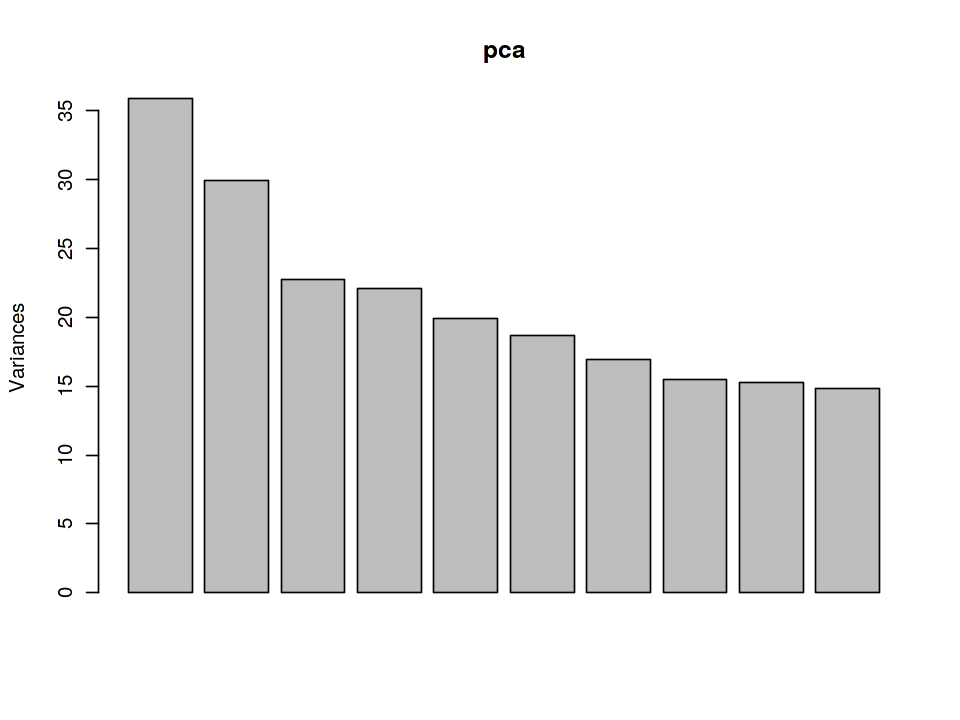

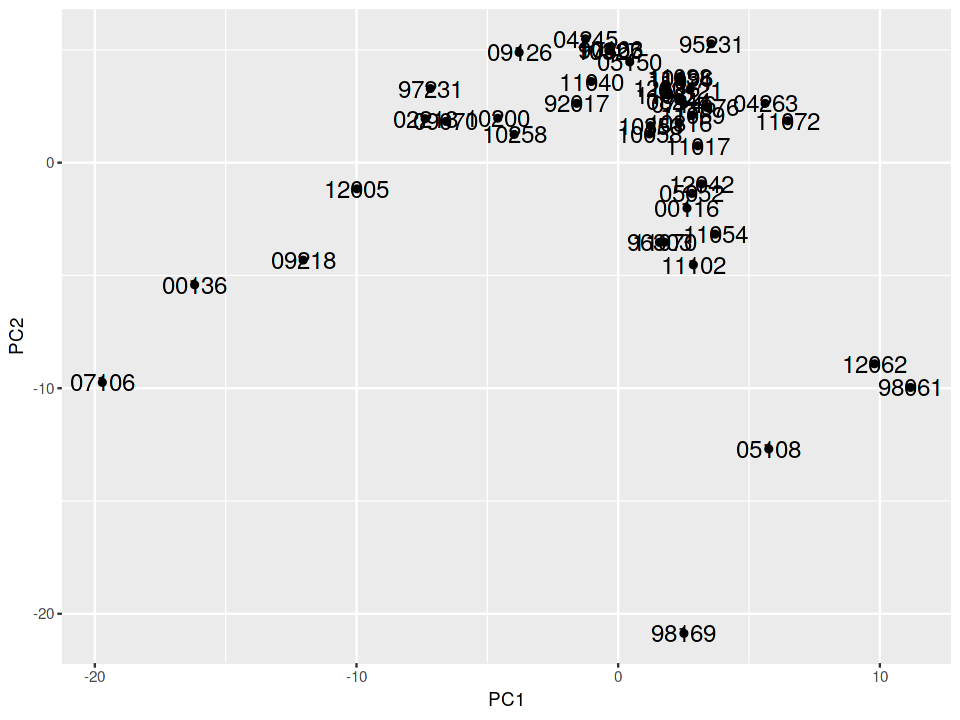

In [67]:
tsne <- Rtsne(t(counts), dims = 2, perplexity=5, verbose=FALSE, max_iter = 500)
pca <- prcomp(t(counts), scale = TRUE)

options(repr.plot.width=8, repr.plot.height=6)
plot(pca)
pcadf = cbind(as.data.frame(pca$x),label=rownames(metadata_of_interest))
ggplot(data = pcadf, aes(x = PC1, y = PC2, label=label)) + geom_point()  + geom_text(size=5)

plotList = preparePCAandTSNEplots(tsne, pca,metadata_of_interest)
all_plots_tsne = plotList$all_plots_tsne
all_plots_pca =  plotList$all_plots_pca

In [68]:
pca_outlier = c('07083','05217','A144_')#,'09126_fro','00136_fro','12005_fro','10200_fro','09218_fro')
#pca_outlier = c()

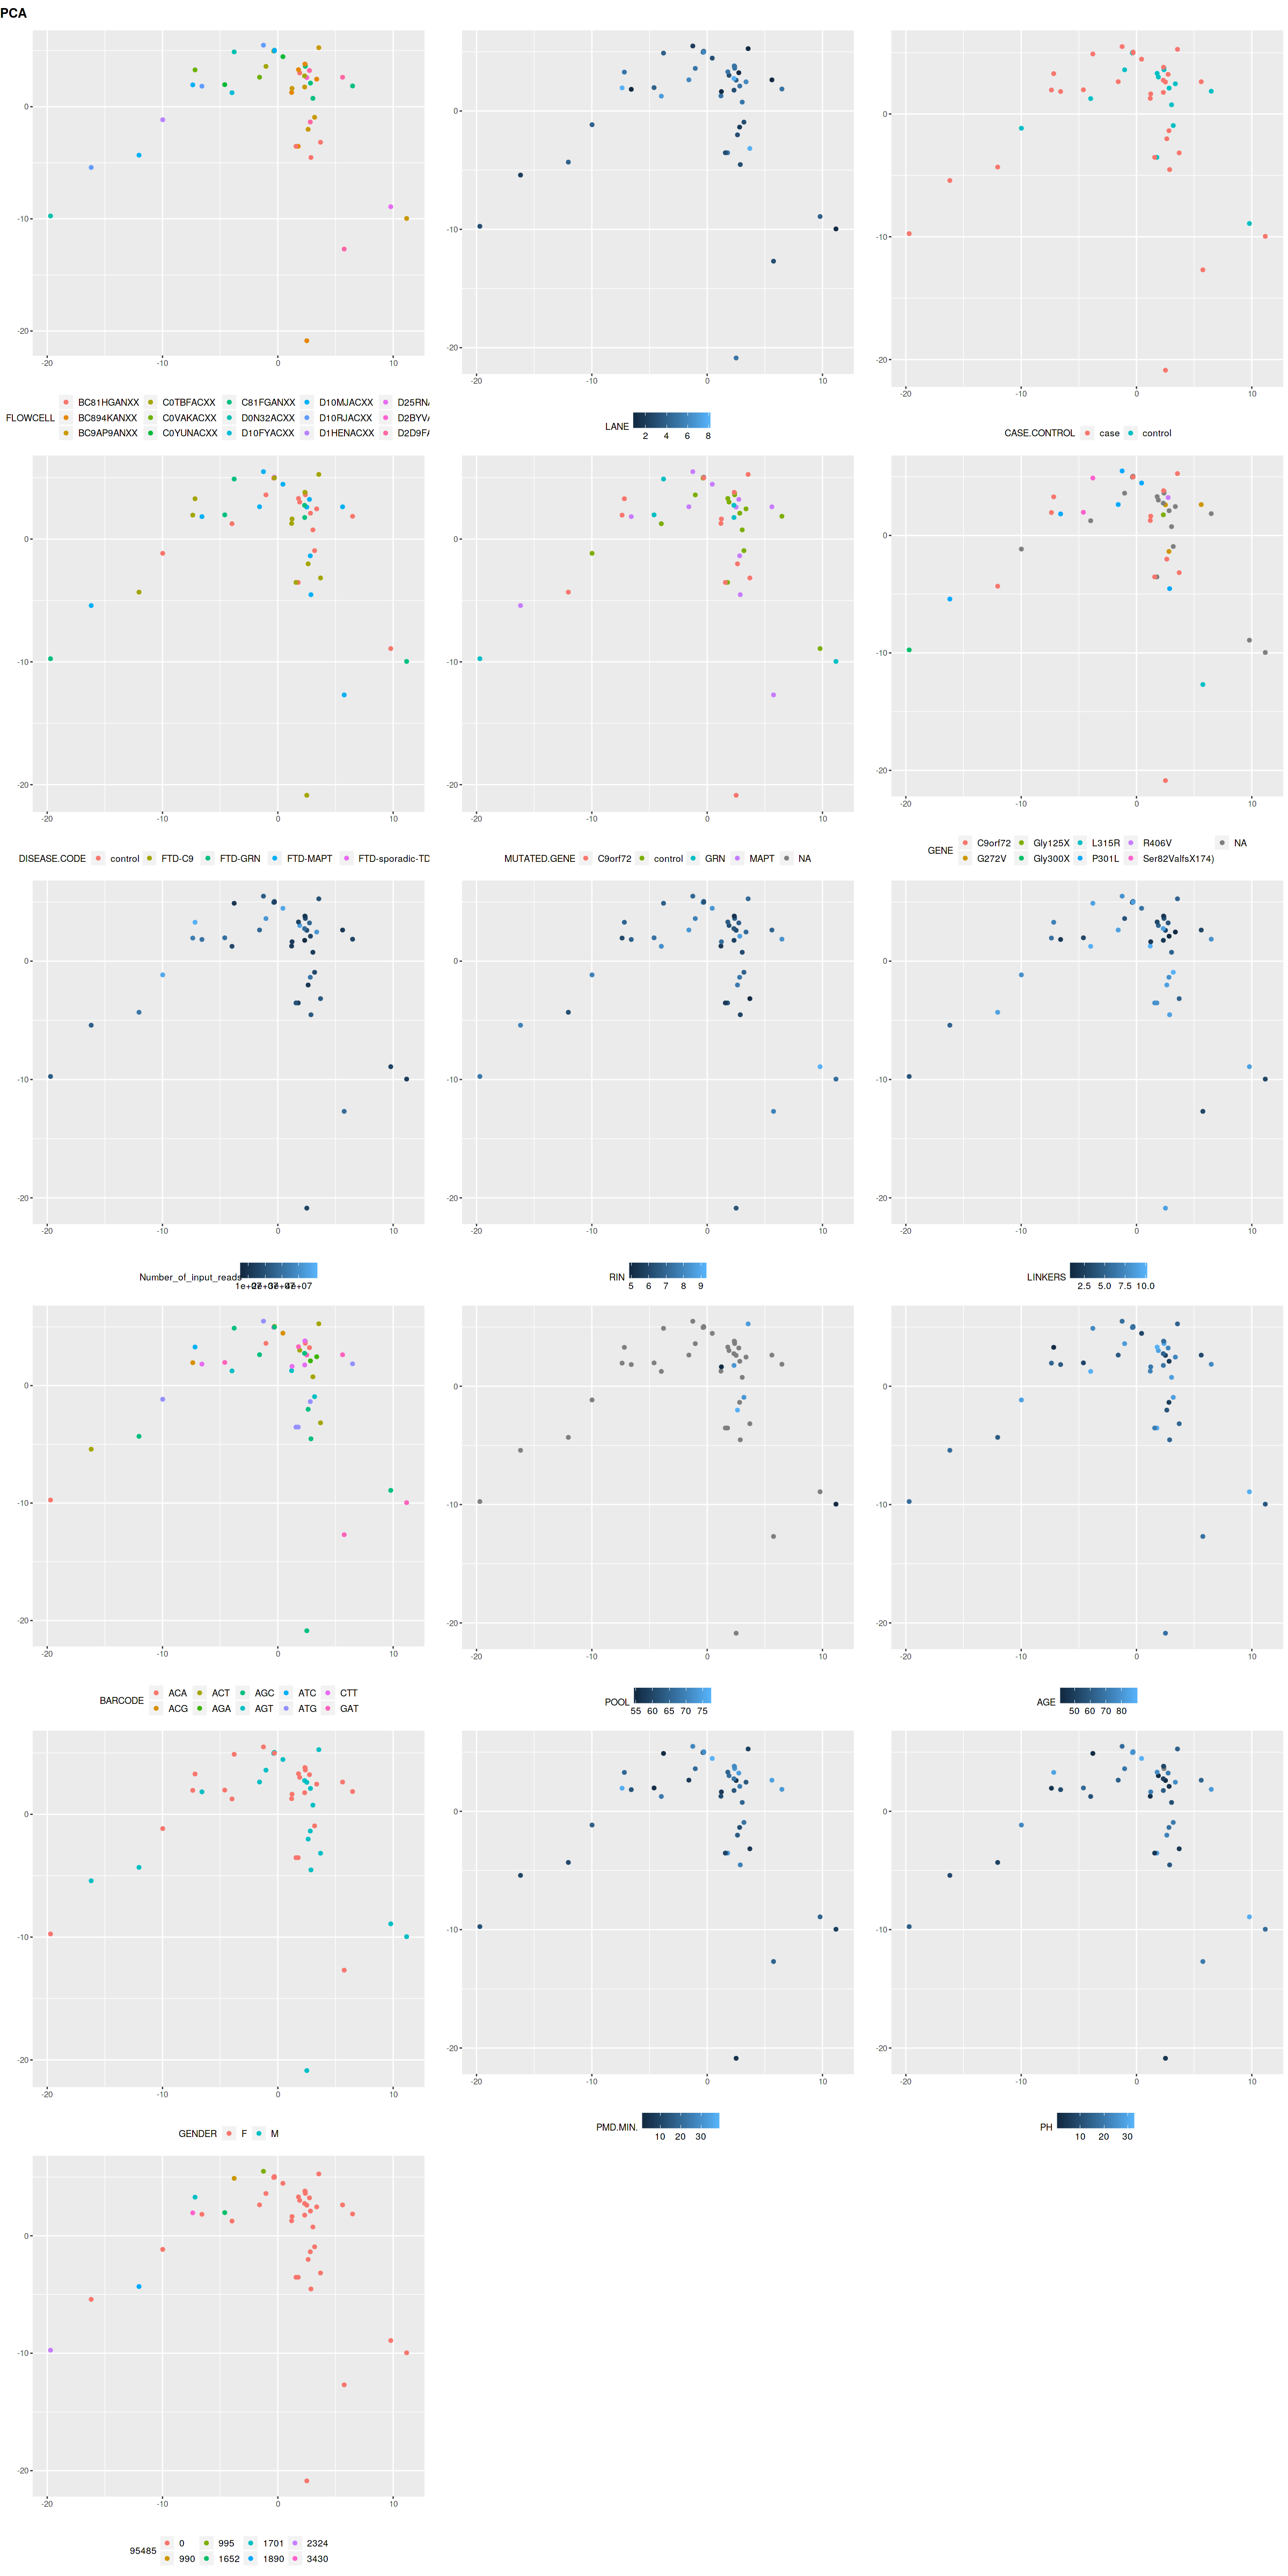

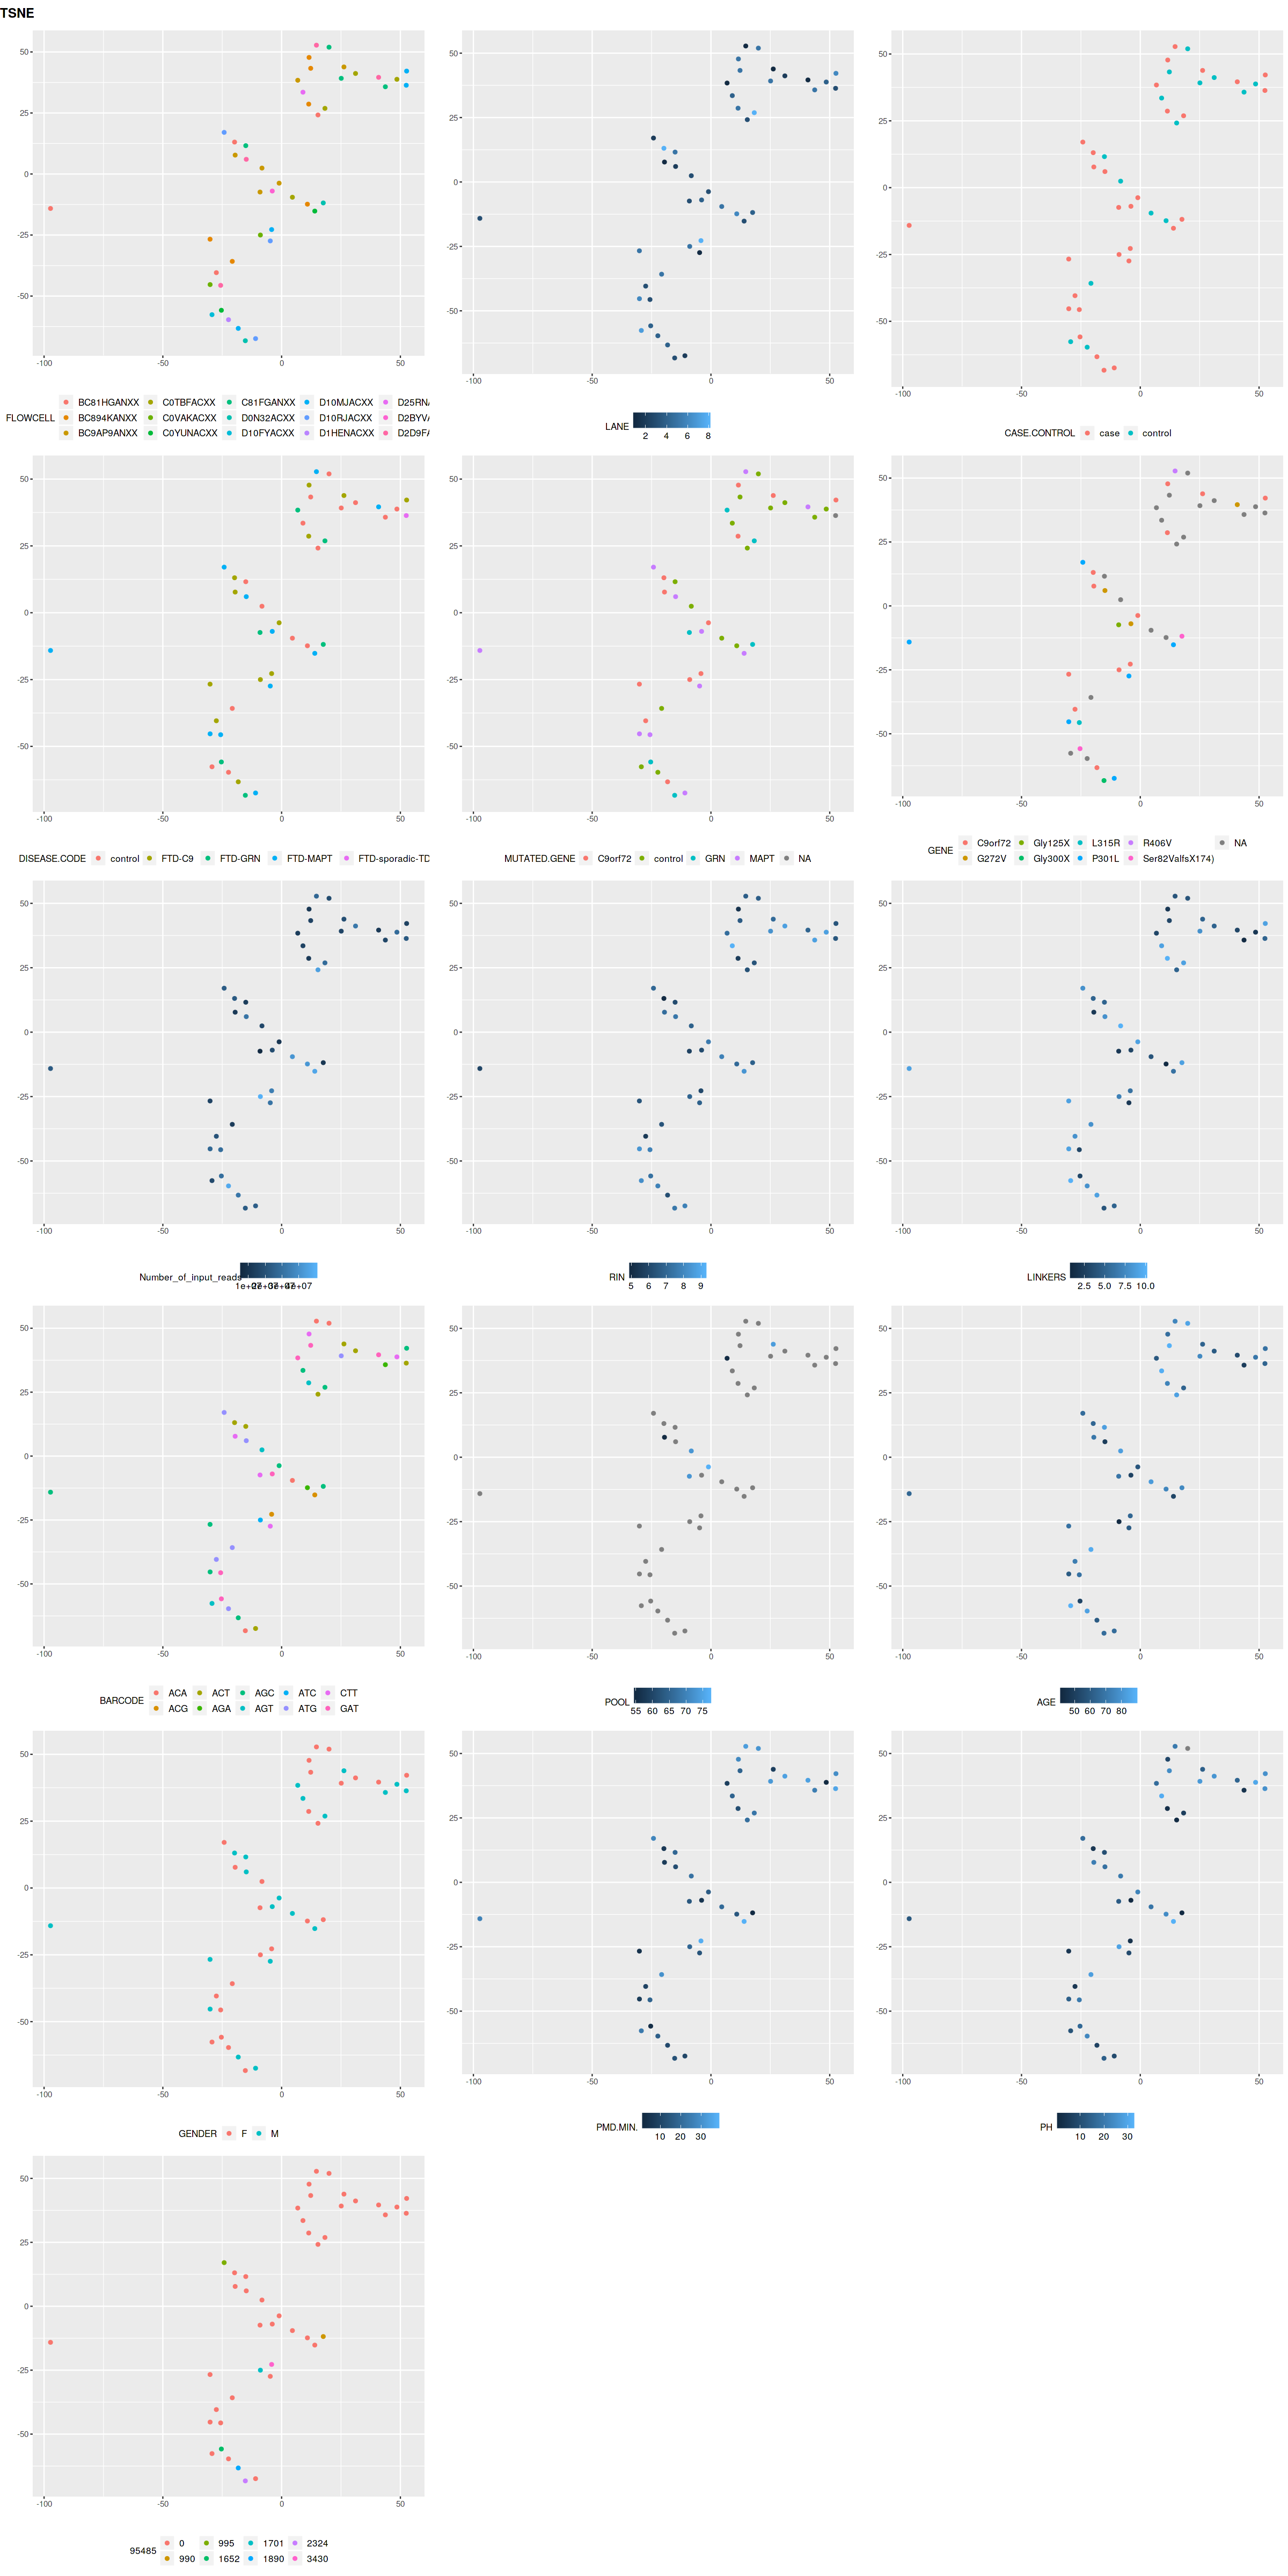

In [69]:
options(repr.plot.width=20, repr.plot.height=40)
cowplot::plot_grid(title_pca, cowplot::plot_grid(plotlist = all_plots_pca, ncol = 3), ncol = 1, rel_heights = c(0.01, 1))
cowplot::plot_grid(title_tsne, cowplot::plot_grid(plotlist = all_plots_tsne, ncol = 3), ncol = 1, rel_heights = c(0.01, 1))

# Differential Expression

In [70]:
samples = rownames(metadata_of_interest)
dds <- DESeqDataSetFromMatrix(countData = counts[,rownames(metadata)],
                              colData = metadata,
                              design= ~ CASE.CONTROL)
dds <- DESeq(dds)
resultsNames(dds) 

converting counts to integer mode

  it appears that the last variable in the design formula, 'CASE.CONTROL',
  has a factor level, 'control', which is not the reference level. we recommend
  to use factor(...,levels=...) or relevel() to set this as the reference level
  before proceeding. for more information, please see the 'Note on factor levels'
  in vignette('DESeq2').

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 327 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"                    "CASE.CONTROL_control_vs_case"

In [71]:
deres = as.data.frame(results(dds, name=resultsNames(dds)[2]))
r = cbind(pathoInfo[rownames(deres),pathoInfoCols],deres)
r = r[r$padj<0.05 & !is.na(r$padj),]
#deres = deres[order(deres$padj),]
r = r[order(r$log2FoldChange),]
r#[grepl("S",r$phylo_level),]

,species_name,phylo_level,parent,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1094466,Flavobacterium indicum GPTSA100-9 = DSM 17447,S1,312277,957.006038,-28.88393,3.105402,-9.301192,1.388803e-20,1.736003e-18
69665,Caulobacter sp. FWC26,S,2648921,454.838727,-27.85302,3.105410,-8.969193,2.986941e-19,1.244559e-17
95485,Burkholderia stabilis,S,87882,220.144848,-26.85486,2.922396,-9.189329,3.953000e-20,2.470625e-18
2565555,Sphingomonas sp. PAMC26645,S,196159,131.383032,-25.71649,3.105450,-8.281085,1.220585e-16,2.702544e-15
87883,Burkholderia multivorans,S,87882,181.246659,-25.69384,3.105435,-8.273831,1.297221e-16,2.702544e-15
28038,Lactobacillus curvatus,S,1578,49.674416,-24.74716,3.105542,-7.968708,1.603423e-15,2.863256e-14
2052837,Neisseriaceae bacterium DSM 100970,S,421605,27.466536,-24.01625,3.105662,-7.733052,1.049980e-14,1.640593e-13
1290,Staphylococcus hominis,S,1279,25.260805,-23.90268,3.105686,-7.696427,1.399232e-14,1.943377e-13
2478662,Acidovorax sp. 1608163,S,2684926,17.446064,-23.40422,3.105816,-7.535609,4.860595e-14,5.335333e-13


Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”


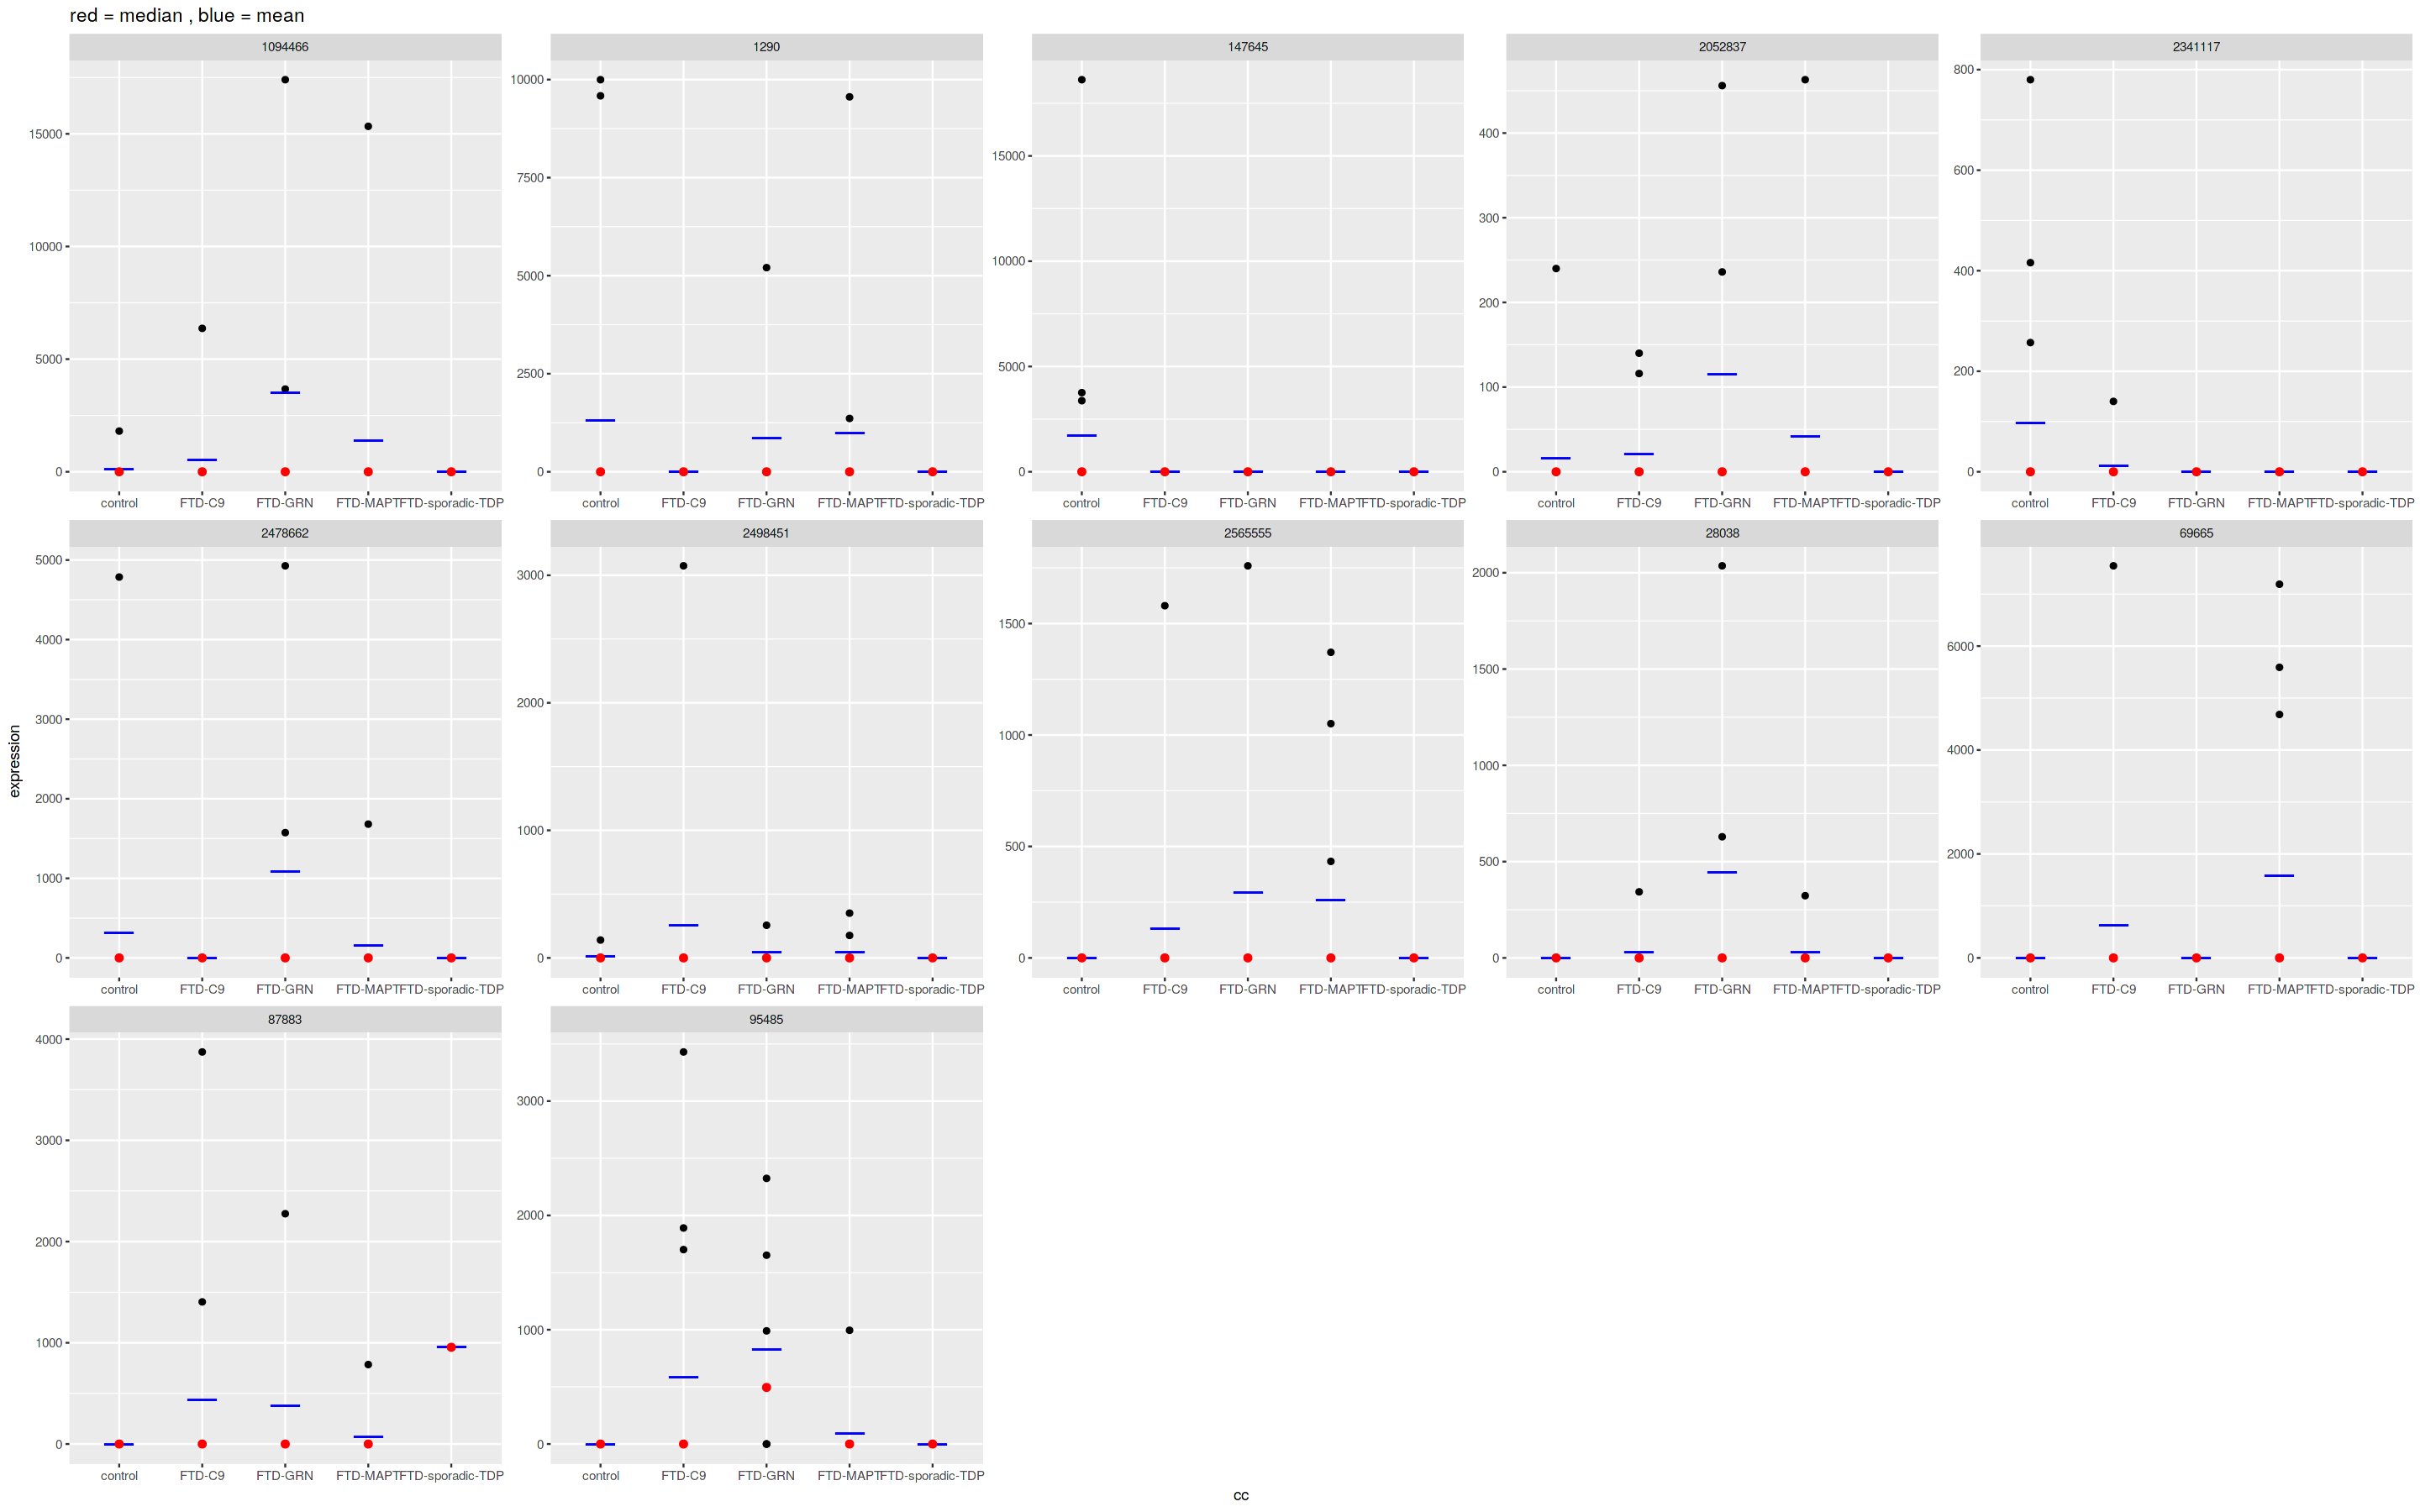

In [75]:
options(repr.plot.width=24, repr.plot.height=15)
printDEresults(counts, samples, rownames(r),metadata_of_interest, "DISEASE.CODE", plotFunction= geom_point())

# Random Forest

In [222]:
metadata_cols_forPrediction = c("FLOWCELL","AGE","GENDER","PH")
#metadata_cols_forPrediction = c("GENDER","PH")
#metadata_cols_forPrediction = c("GENDER")

In [225]:
df_rf = cbind(metadata_of_interest[,c(metadata_cols_forPrediction,"CASE.CONTROL")],t(counts[rowSums(counts==0)<length(counts)-7,rownames(metadata_of_interest)]))
df_rf[is.na(df_rf$PH),"PH"] = median(df_rf$PH, na.rm = TRUE)
colnames(df_rf) = make.names(colnames(df_rf))
df_rf

,FLOWCELL,AGE,GENDER,PH,CASE.CONTROL,X1969841,X1491,X44283,X2184519,X72407,⋯,X11970,X755732,X2702,X527029,X11780,X2057025,X526227,X1922225,X2003188,X11807
,<fct>,<int>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
98169,BC894KANXX,68,M,4.0,case,784878,275687,250349,182899,148016,⋯,205,376,244,640,180,127,0,0,0,0
00116,BC9AP9ANXX,58,M,22.0,case,787603,211559,178052,146714,111606,⋯,0,0,0,0,282,0,0,0,0,112
00136,D10RJACXX,66,M,9.0,case,1767160,565891,314226,338136,219617,⋯,490,0,354,324,209,0,276,113,0,0
02218,D10MJACXX,64,F,3.0,case,815657,107180,193425,92401,203689,⋯,0,0,0,0,0,0,337,188,111,0
03121,D2D9FACXX,75,F,20.0,case,409385,135795,84103,90792,95668,⋯,0,182,0,0,0,314,0,0,0,152
04245,D10RJACXX,66,F,17.0,case,658210,157907,82057,140170,125445,⋯,0,0,0,0,0,0,110,0,0,0
04263,D2D9FACXX,54,F,15.0,case,611432,129659,115603,88644,109171,⋯,0,268,0,0,0,0,0,0,0,0
05052,D2D9FACXX,49,M,18.0,case,674349,180864,150475,122950,110018,⋯,184,0,0,0,0,0,0,0,0,0
05108,D2D9FACXX,68,F,20.0,case,1011913,287619,247195,190231,140268,⋯,0,563,183,0,0,316,0,0,185,0


In [226]:
tt = getTrainTestSet(df_rf, percentageTraining= 0.7)
table(df_rf$CASE.CONTROL)
ctrl <- trainControl(method = "cv",classProbs = TRUE, summaryFunction = twoClassSummary)
nmin <- sum(tt$train$CASE.CONTROL=="control")

myrf=randomForest(CASE.CONTROL ~ . , data = tt$train, 
                  trControl = ctrl,
                  strata = tt$train$CASE.CONTROL, sampsize = rep(nmin, 2))

print("TRAINED RANDOM FOREST CLASSIFYING CASE.CONTROL")
myrf


   case control 
     30      15 

[1] "TRAINED RANDOM FOREST CLASSIFYING CASE.CONTROL"



Call:
 randomForest(formula = CASE.CONTROL ~ ., data = tt$train, trControl = ctrl,      strata = tt$train$CASE.CONTROL, sampsize = rep(nmin, 2)) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 9

        OOB estimate of  error rate: 19.35%
Confusion matrix:
        case control class.error
case      19       3   0.1363636
control    3       6   0.3333333

[1] "TESTSET CONFUSION MATRIX"


Confusion Matrix and Statistics

          Reference
Prediction case control
   case       6       2
   control    2       4
                                         
               Accuracy : 0.7143         
                 95% CI : (0.419, 0.9161)
    No Information Rate : 0.5714         
    P-Value [Acc > NIR] : 0.2109         
                                         
                  Kappa : 0.4167         
                                         
 Mcnemar's Test P-Value : 1.0000         
                                         
            Sensitivity : 0.7500         
            Specificity : 0.6667         
         Pos Pred Value : 0.7500         
         Neg Pred Value : 0.6667         
             Prevalence : 0.5714         
         Detection Rate : 0.4286         
   Detection Prevalence : 0.5714         
      Balanced Accuracy : 0.7083         
                                         
       'Positive' Class : case           
                                   

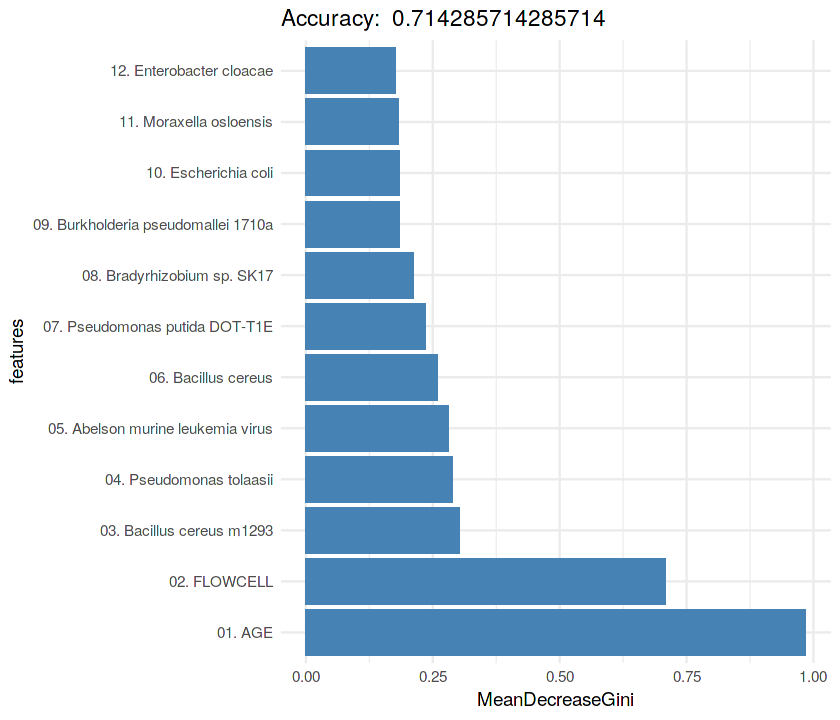

In [227]:
print("TESTSET CONFUSION MATRIX")
prediction = predict(myrf, tt$test, OOB=TRUE, type = "response")
cm = confusionMatrix(prediction, tt$test$CASE.CONTROL)
cm
tit = paste("Accuracy: ", cm$overall["Accuracy"])
options(repr.plot.width=7, repr.plot.height=6)
imp = as.data.frame(importance(myrf))
features = rownames(imp)
features[grepl("X",features)] = as.character(pathoInfo[gsub("X","",features[grepl("X",features)]),"species_name"])
imp = cbind(imp, features)
imp = imp[order(imp$MeanDecreaseGini, decreasing = TRUE),]
imp$features = paste(seq(dim(imp)[1]),imp$features, sep = ". ")
imp$features[1:9] = paste(0, imp$features[1:9], sep = "")

ggplot(imp[1:12,], aes(x=features, y = MeanDecreaseGini)) + geom_bar(stat="identity", fill= "steelblue") + coord_flip() + theme_minimal() + ggtitle(tit)
